In [2]:
from argparse import Namespace
import logging
import os
from pathlib import Path
import random

logger = logging.getLogger('model_test')

model_path = Path('EXPERIMENTS/models/models_20241203_15_18_45_hof3-2024-12-03/')
eval_data = Path('EXPERIMENTS/trajectron-data/hof3-nostep-2024-12-03_test.pkl')

In [3]:

from trap.frame_emitter import Camera

maps = None

path = Path("EXPERIMENTS/raw/hof3/")
calibration_path = Path("../DATASETS/hof3/calibration.json")
homography_path = Path("../DATASETS/hof3/homography.json")
camera = Camera.from_paths(calibration_path, homography_path, 12)


In [ ]:
from trap.tracker import FinalDisplacementFilter, TrackReader


reader = TrackReader(path, camera.fps, exclude_whitelisted = False, include_blacklisted=False)
tracks = [t for t in reader]
filter = FinalDisplacementFilter(2) # people don't just (disappear) out of nowhere
tracks = filter.apply(tracks, camera)
len(tracks)

2682

In [35]:
# Choose one of the model directory names under the experiment/*/models folders.
# Possibilities are 'vel_ee', 'int_ee', 'int_ee_me', or 'robot'
# model_dir = os.path.join(self.config.log_dir, 'int_ee')
# model_dir = 'models/models_04_Oct_2023_21_04_48_eth_vel_ar3'

# Load hyperparameters from json
import json
import dill
from trajectron.utils import prediction_output_to_trajectories
from trajectron.model.online.online_trajectron import OnlineTrajectron
from trajectron.model.model_registrar import ModelRegistrar
from trap.prediction_server import create_online_env

eval_device = "cuda:0"
config_file = model_path / 'config.json'
if not os.path.exists(config_file):
    raise ValueError('Config json not found!')
with open(config_file, 'r') as conf_json:
    logger.info(f"Load config from {config_file}")
    hyperparams = json.load(conf_json)

logger.info(f"Use hyperparams: {hyperparams=}")

with open(eval_data, 'rb') as f:
    eval_env = dill.load(f, encoding='latin1')

logger.info('Loaded data from %s' % (eval_data,))

# Creating a dummy environment with a single scene that contains information about the world.
# When using this code, feel free to use whichever scene index or initial timestep you wish.
scene_idx = 0

# You need to have at least acceleration, so you want 2 timesteps of prior data, e.g. [0, 1],
# so that you can immediately start incremental inference from the 3rd timestep onwards.
init_timestep = 2

eval_scene = eval_env.scenes[scene_idx]
print(eval_scene, eval_scene.dt)
online_env = create_online_env(eval_env, hyperparams, scene_idx, init_timestep)

# auto-find highest iteration
model_registrar = ModelRegistrar(model_path, eval_device)
model_iterations = model_path.glob('model_registrar-*.pt')
highest_iter = max([int(p.stem.split('-')[-1]) for p in model_iterations])
logger.info(f"Loading model {highest_iter}")

model_registrar.load_models(iter_num=highest_iter)

trajectron = OnlineTrajectron(model_registrar,
                            hyperparams,
                            eval_device)

# If you want to see what different robot futures do to the predictions, uncomment this line as well as
# related "... += adjustment" lines below.
# adjustment = np.stack([np.arange(13)/float(i*2.0) for i in range(6, 12)], axis=1)

# Here's how you'd incrementally run the model, e.g. with streaming data.
trajectron.set_environment(online_env, init_timestep)


Scene: Duration: 31556.25s, Nodes: 94, Map: No. 0.08333333333333333

Loading from EXPERIMENTS/models/models_20241203_15_18_45_hof3-2024-12-03/model_registrar-100.pt
Loaded!



In [36]:
track = tracks[9]
track = tracks[20]
track = tracks[21]

In [37]:
len(track.history)

139

In [38]:
from trap.tracker import Smoother


t = track.get_with_interpolated_history()
# node = t.to_trajectron_node(camera, online_env)

smoother = Smoother()
track_s = smoother.smooth_track(t)
track_s.track_id += "smooth"


In [39]:
input_tracks =[
    t,
    track_s
]

In [40]:
eval_scene.get_clipped_input_dict(238525, hyperparams['state'])
# eval_scene.nodes[0].first_timestep

{PEDESTRIAN/97903: array([[     2.1625,      7.7215,       0.894,     0.45824,    -0.52067,     -1.0788]])}

/home/ruben/suspicion/trap/.venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/home/ruben/suspicion/trap/.venv/lib/python3.10/site-packages/torch/distributions/distribution.py:44: UserWarning: <class 'trajectron.model.components.gmm2d.GMM2D'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +
/home/ruben/suspicion/trap/.venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:769: UserWarning: RNN module weights are not part of si

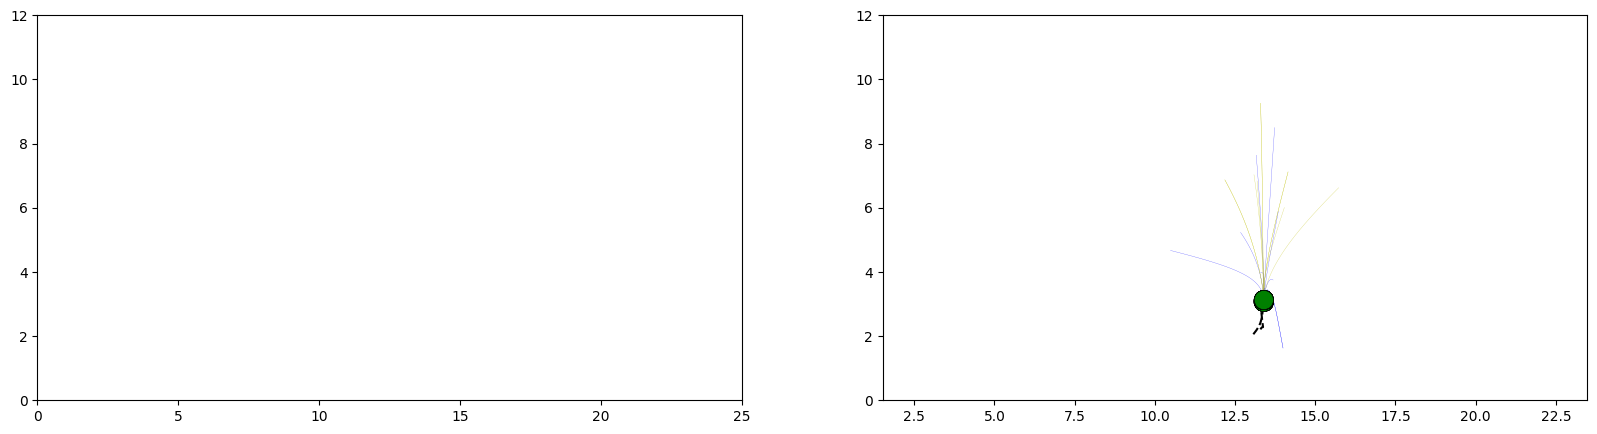

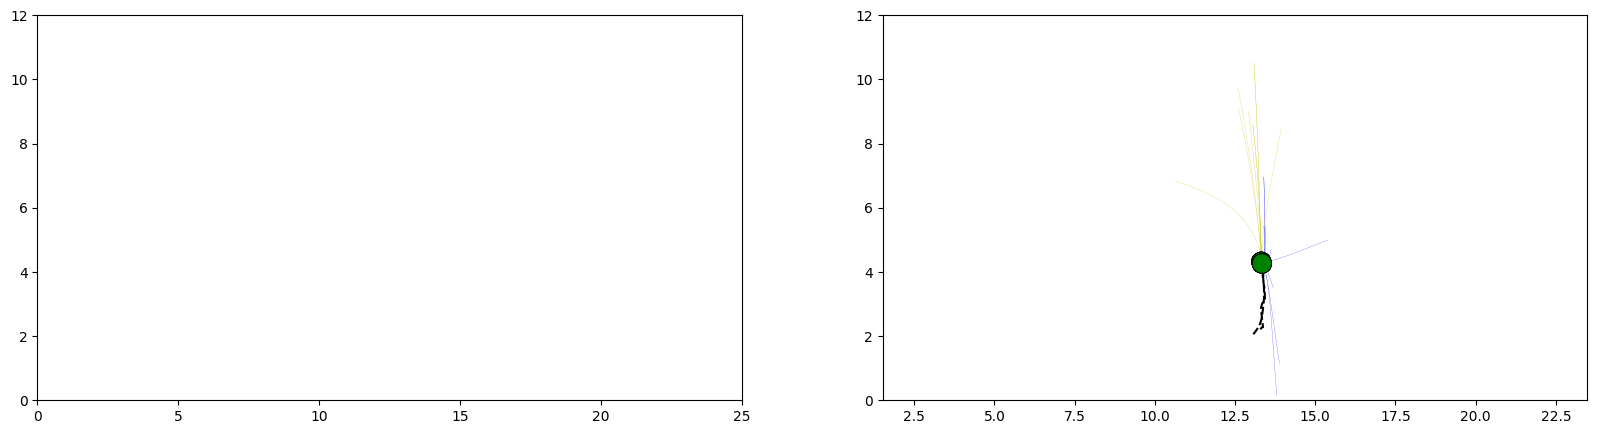

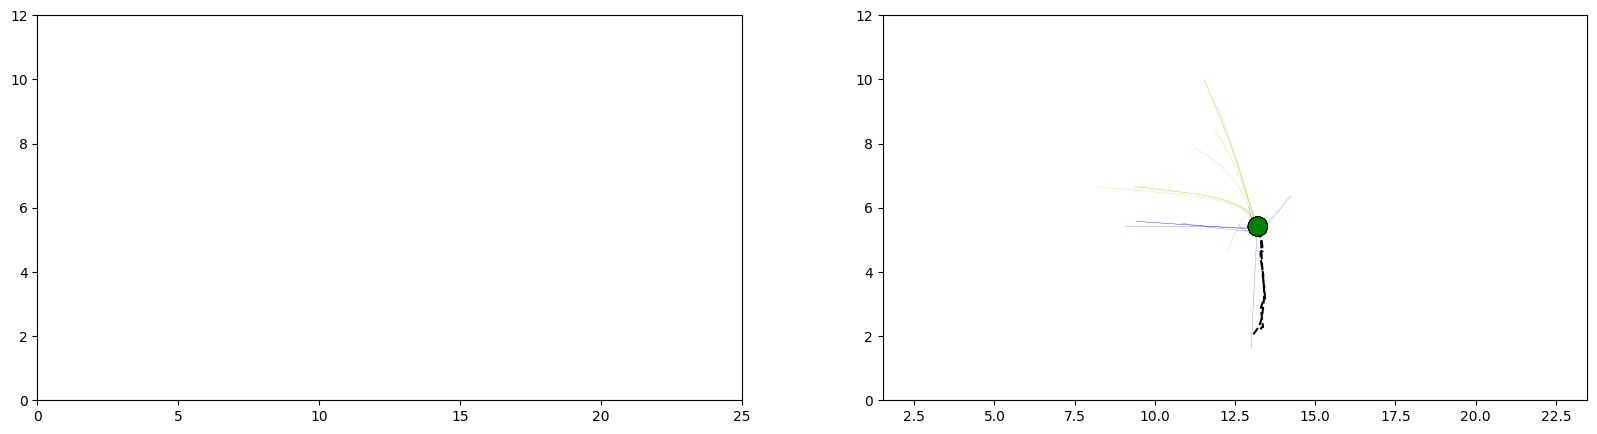

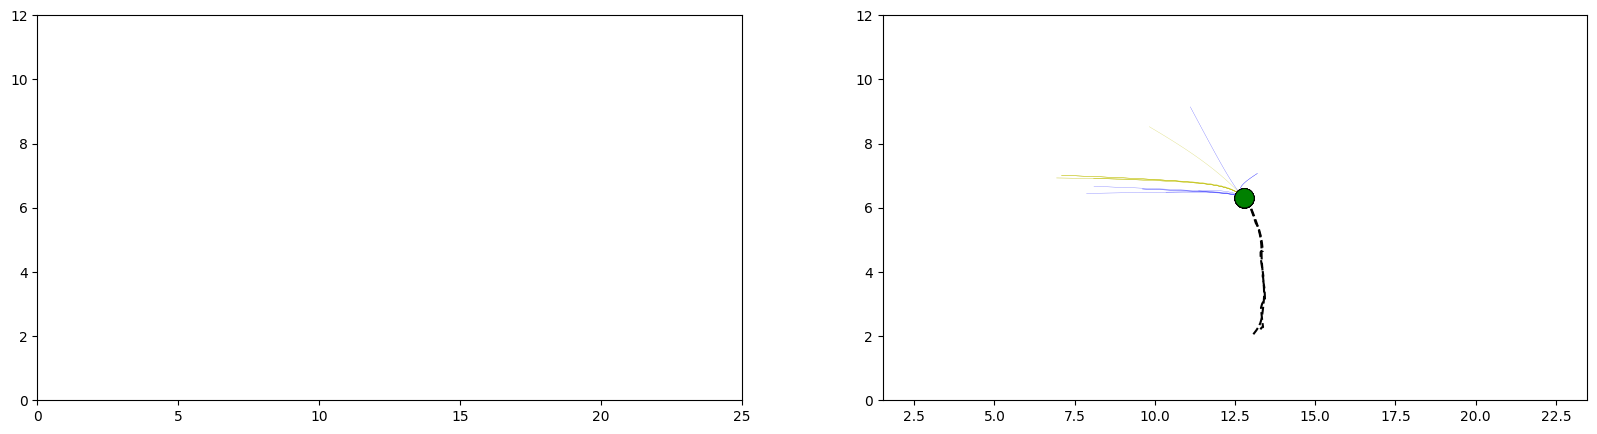

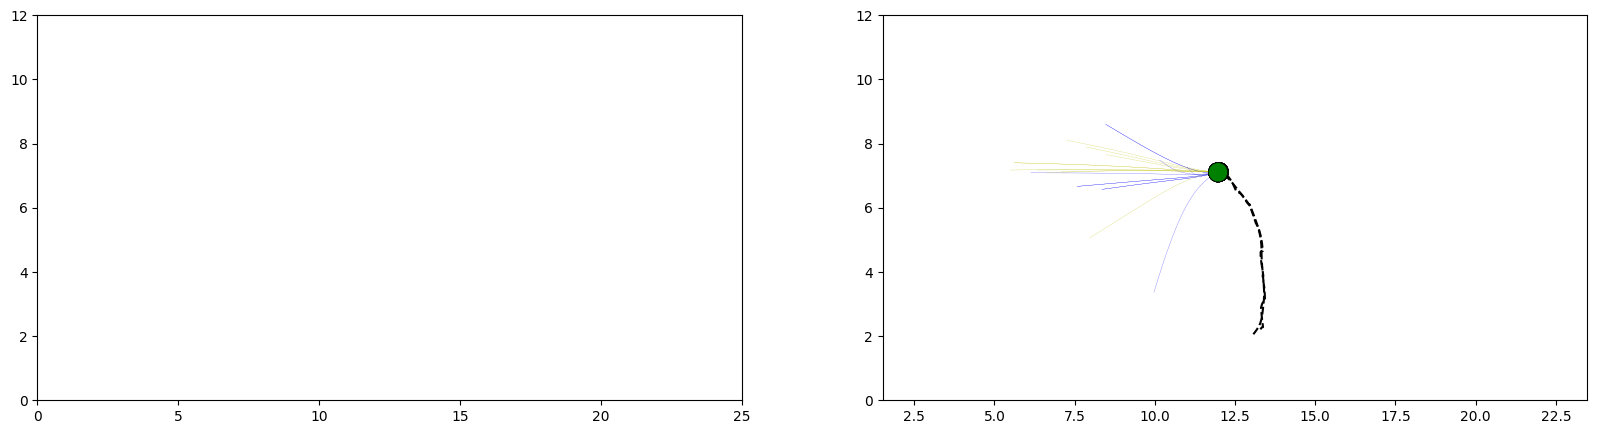

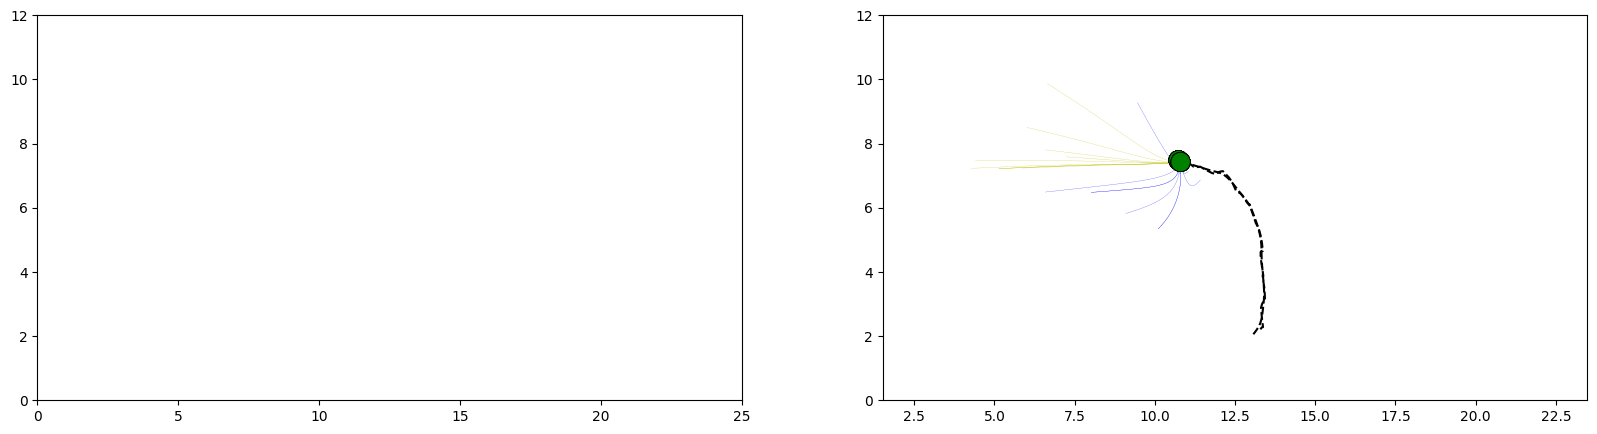

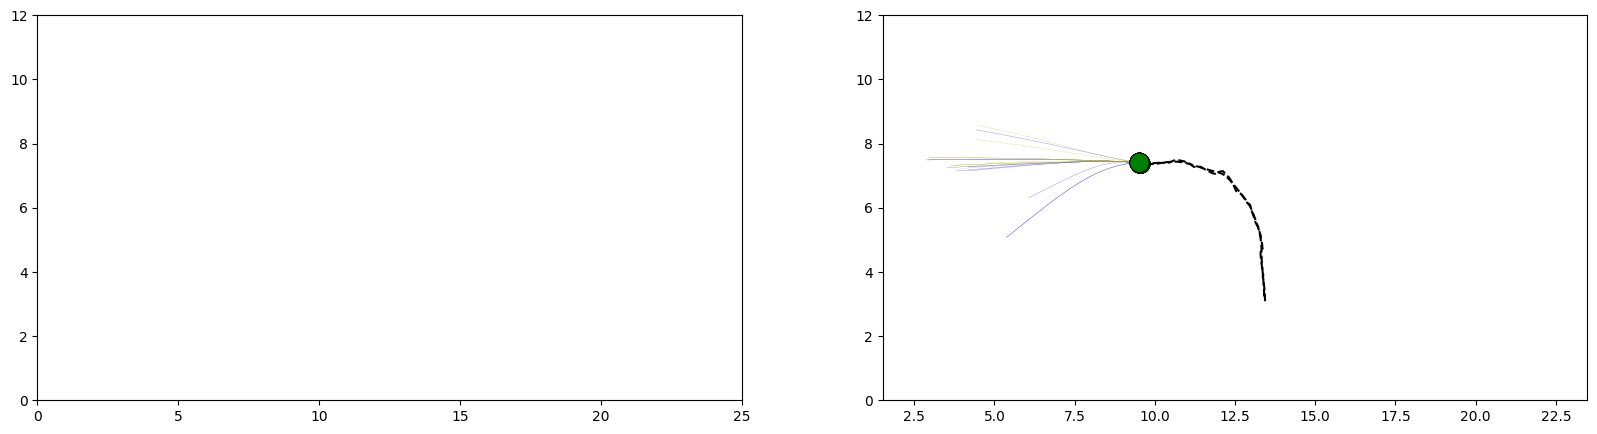

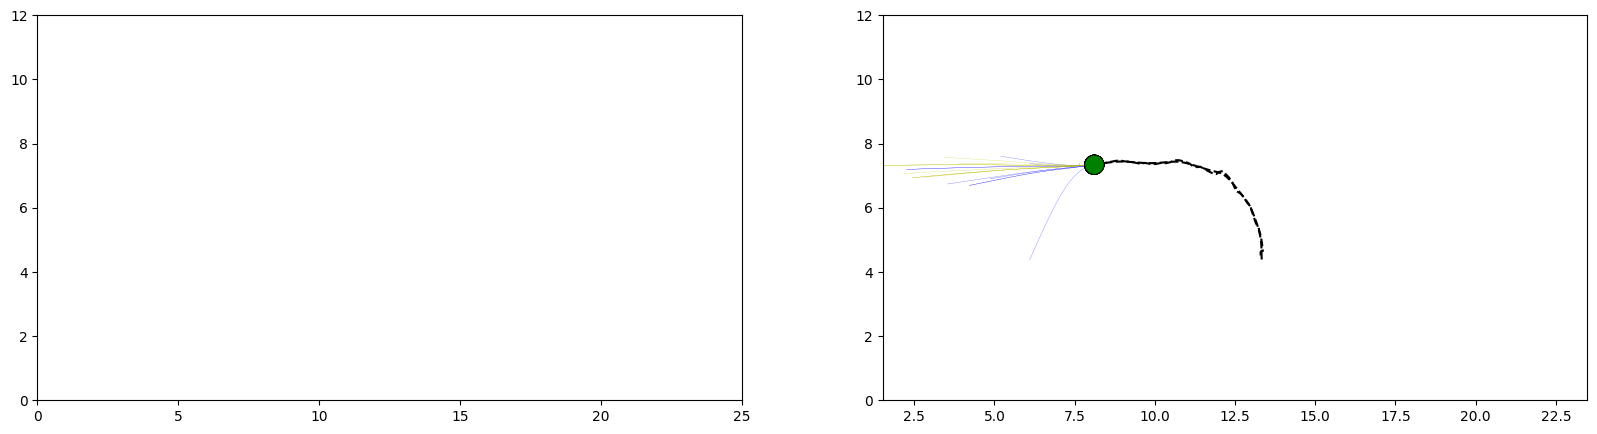

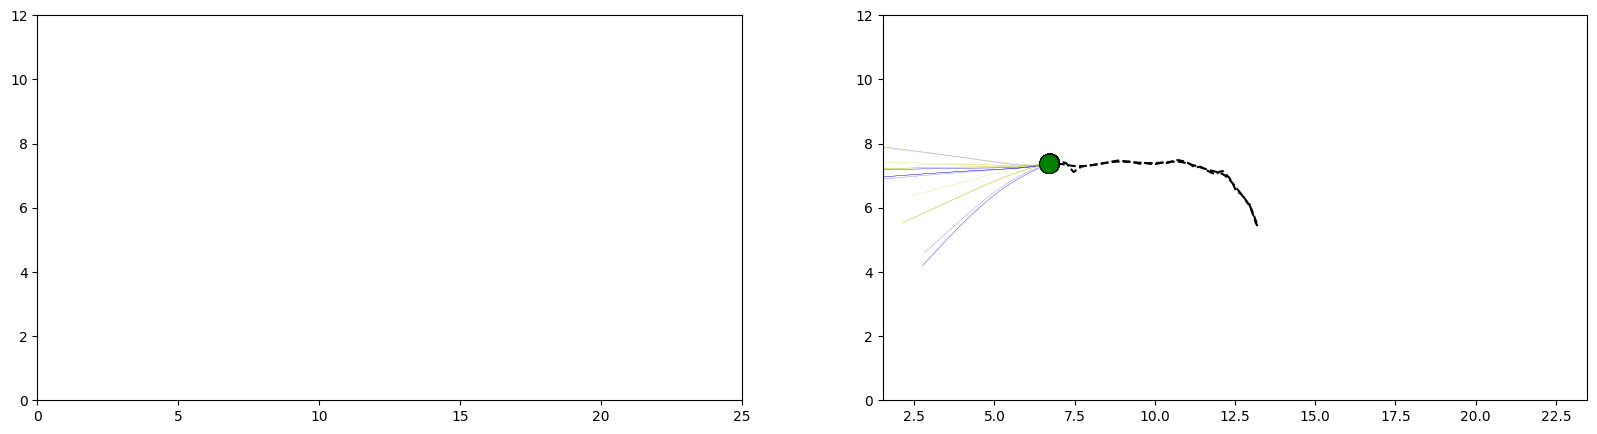

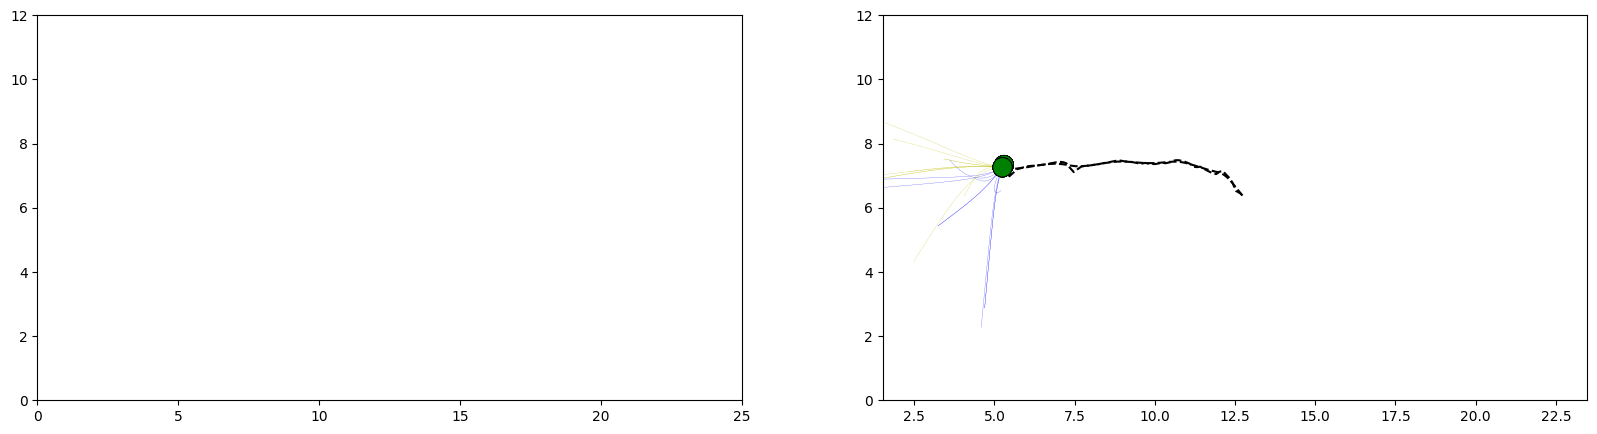

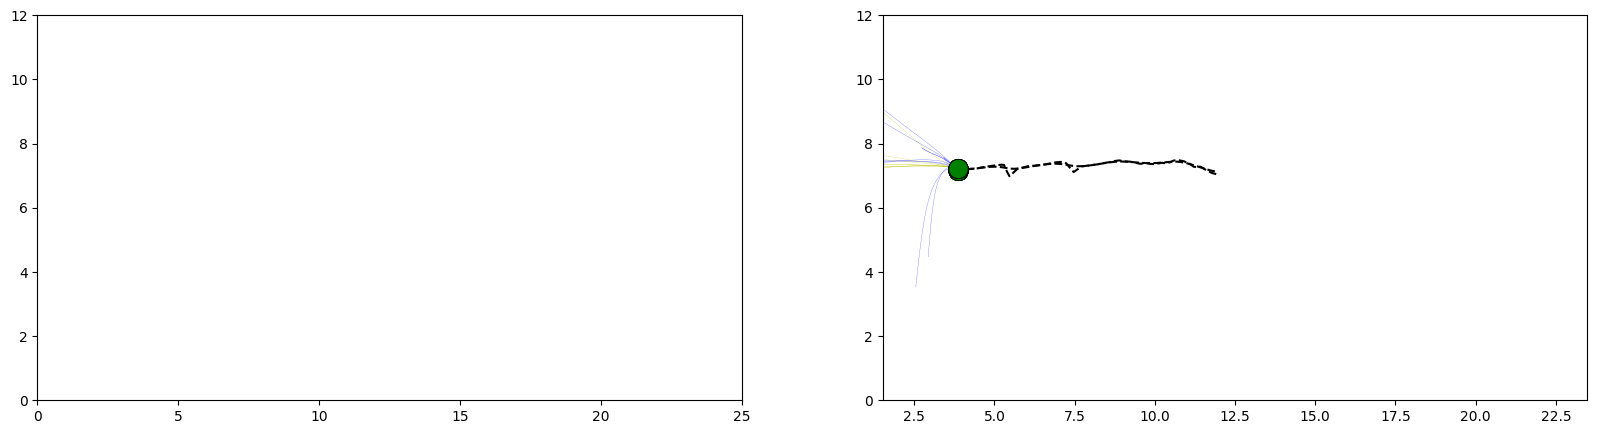

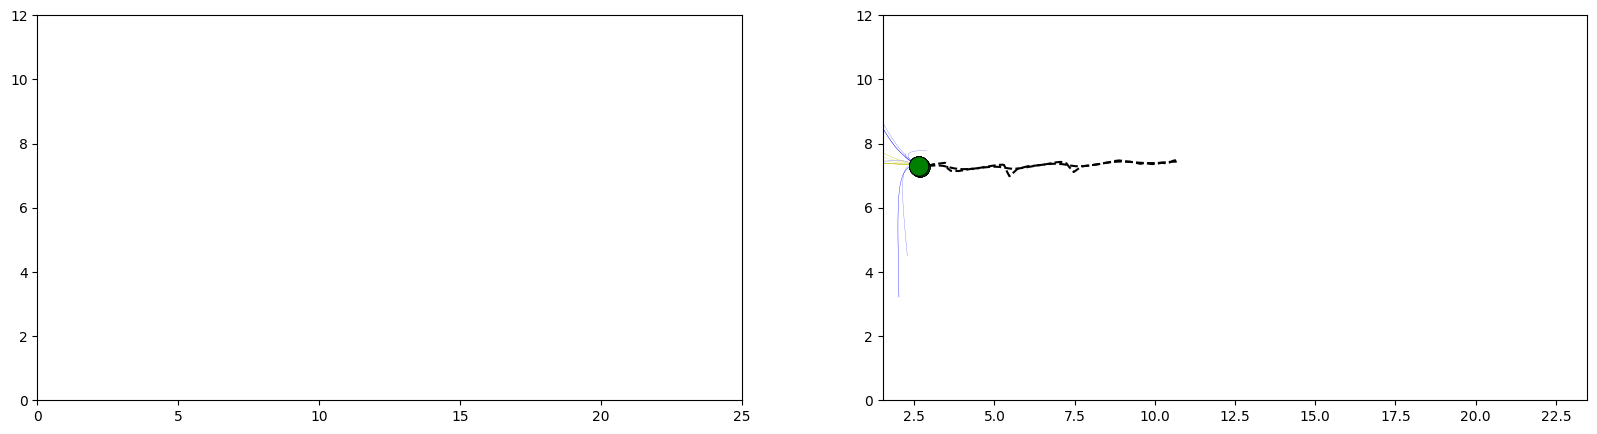

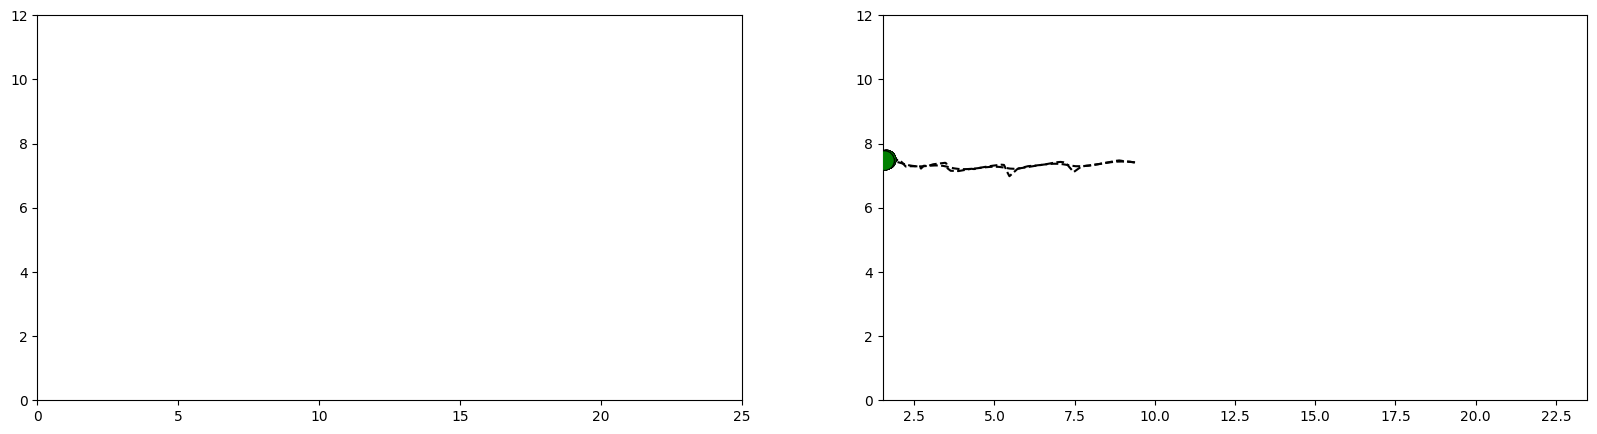

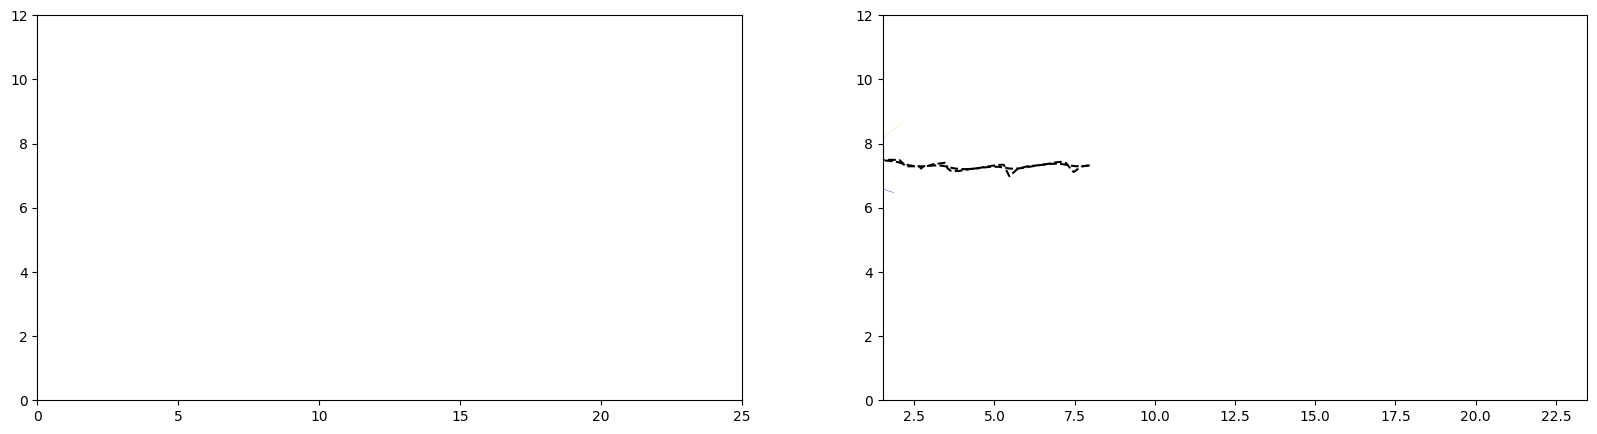

In [41]:
from matplotlib import pyplot as plt
import numpy as np

import trajectron.visualization as vis
# print(node.data.data)


for i in range(len(t.history)):
    timestep  = i+1
    input_dict =  {}
    # print(node.data.data[-1])
    for t in input_tracks:
        node = t.to_trajectron_node(camera, online_env)
        node.first_timestep = 0 # reset loaded track timestep
        input_dict[node] = np.array(object=[node.data.data[i]])
    # print(node.data.data[i])

    dists, preds = trajectron.incremental_forward(input_dict,
                                                maps,
                                                prediction_horizon=50,
                                                num_samples=10,
                                                full_dist=False,
                                                gmm_mode=True)
    prediction_dict, histories_dict, futures_dict = prediction_output_to_trajectories({timestep: preds},
                                                eval_scene.dt,
                                                hyperparams['maximum_history_length'],
                                                hyperparams['prediction_horizon']
                                                )
    # print(trajectron.node_data[node]._right_index%trajectron.node_data[node]._capacity)
    # # print(len(preds[node][0][0]))
    # print(
    #     len(prediction_dict[timestep][node]),
    #     len(histories_dict[timestep][node]),
    #     len(futures_dict[timestep][node])
    #     )

    if timestep > 2 and (timestep%10 == 0):
        fig = plt.figure(figsize=(20,5))
        (ax1, ax2) = fig.subplots(1,2)
        vis.visualize_distribution(ax1,
                                    dists)
        
        vis.visualize_prediction(ax2,
                                    {timestep: preds},
                                    eval_scene.dt,
                                    hyperparams['maximum_history_length'],
                                    hyperparams['prediction_horizon'])
        [ax.set_xlim([0, 25]) for ax in [ax1, ax2]]
        [ax.set_ylim([0, 12]) for ax in [ax1, ax2]]
        fig.show()
    


In [11]:
position_state = {'position': ['x', 'y']}
node.first_timestep = 0
history = node.get(np.array([timestep-30,timestep]), position_state)
history[~np.isnan(history.sum(axis=1))]

array([[     3.5313,      7.4048],
       [     3.4009,      7.4108],
       [      3.283,      7.4148],
       [     3.1773,      7.4189],
       [     3.0799,      7.4246],
       [     2.9867,      7.4343],
       [      2.895,      7.4478],
       [     2.8033,      7.4638],
       [     2.7102,      7.4809],
       [     2.6148,      7.4974],
       [     2.5164,      7.5119],
       [     2.4143,      7.5233],
       [      2.308,      7.5314],
       [     2.1988,      7.5376],
       [     2.0887,      7.5438],
       [     1.9807,      7.5519],
       [       1.88,      7.5653],
       [      1.786,      7.5849],
       [     1.6948,      7.6096],
       [     1.6013,      7.6312],
       [     1.5074,      7.6483],
       [     1.4168,      7.6609],
       [     1.3341,      7.6697],
       [     1.2634,      7.6755],
       [     1.2049,      7.6787],
       [     1.1542,      7.6785],
       [     1.1072,      7.6745],
       [      1.061,      7.6669],
       [     1.0157,